In [63]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from torch.utils.data import (
    Dataset,
    DataLoader,
)
import pandas as pd
import os
import imageio
import cv2
from PIL import Image


In [ ]:
import os
from pathlib import Path
import csv

rootdir = 'C:/Users/laraib.zafar/FYP/Dataset Generation/External Dataset/'

for subdir, dirs, files in os.walk(rootdir):
    directoryName =subdir.split('/')
    currentSubDirectory=directoryName[6]
    for path in Path(subdir).iterdir():
        if path.is_file():
            
            currentFileName = path.stem
            fileExtension = path.suffix
            parentDirectory = path.parent

            cleanFileName = currentFileName.replace('img','_')

            newFileName = currentSubDirectory + cleanFileName + fileExtension
            path.rename(Path(parentDirectory, newFileName))
            with open('labels.csv', 'a', newline='') as csvfile:
              spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
              spamwriter.writerow([newFileName]) 

In [ ]:
import os
from pathlib import Path
import csv

rootdir = 'C:/Users/laraib.zafar/FYP/Dataset Generation/Home stuff/'

for subdir, dirs, files in os.walk(rootdir):
    directoryName =subdir.split('/')
    currentSubDirectory=directoryName[6]
    count=2000
    for path in Path(subdir).iterdir():
        if path.is_file():
            
            currentFileName = path.stem
            fileExtension = path.suffix
            parentDirectory = path.parent

            newFileName = currentSubDirectory + '_' + str(count) + fileExtension
            count +=1
            path.rename(Path(parentDirectory, newFileName))
            with open('labels.csv', 'a', newline='') as csvfile:
              spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
              spamwriter.writerow([newFileName]) 

In [64]:
class ClassificationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        print(self.annotations)
        self.root_dir = root_dir
        self.transform = transform
    
    def __new__(cls, csv_file, root_dir, transform=None):
        return super(ChairAndDoorsDataset, cls).__new__(cls)
     
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        
        image = cv2.imread(img_path)
        image=Image.fromarray(image)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [65]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [66]:
dataset = ClassificationDataset(
    csv_file="labelsI.csv",
    root_dir="Combined_1",
    transform=train_transforms)

batch_size=12
train_set, test_set = torch.utils.data.random_split(dataset, [5500,1079 ])
train_loader = DataLoader(dataset=train_set, batch_size=12, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=12, shuffle=True)

               Object  Label
0           bed_0.jpg      0
1           bed_1.jpg      0
2          bed_10.jpg      0
3         bed_100.jpg      0
4        bed_1000.jpg      0
...               ...    ...
6574  table_2028.jpeg      4
6575  table_2029.jpeg      4
6576  table_2030.jpeg      4
6577  table_2031.jpeg      4
6578  table_2032.jpeg      4

[6579 rows x 2 columns]


<ipython-input-67-df7eff1f3c50>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats

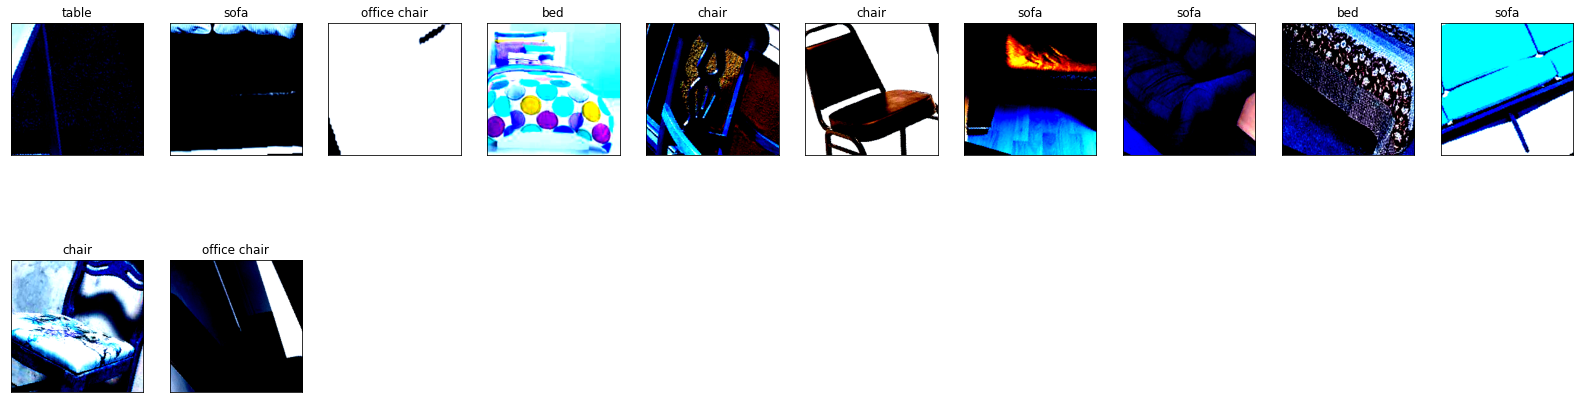

In [67]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
numpyImages = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(28, 8))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(numpyImages[idx], (1, 2, 0)))
    classes=['bed','chair','office chair','sofa','table']
    ax.set_title(classes[labels[idx]])

In [81]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
#model = models.resnet18(pretrained=True)
#model = models.segmentation.fcn_resnet50(pretrained=True, num_classes=5)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

    
#Restnet 18
# model.fc = nn.Sequential(nn.Linear(512, 128),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(128, 5),
#                                  nn.LogSoftmax(dim=1))
    
#Resnet 50    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 5),
                                 nn.LogSoftmax(dim=1))

# model.classifier = nn.Sequential(nn.Linear(2048, 1024),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(1024, 512),
#                                  nn.LogSoftmax(dim=1))

# model.aux_classifier = nn.Sequential(nn.Linear(512, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 5),
#                                  nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
#Adam => same as stochastic gradient descent + Momentum
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
for param in model.parameters():
  print(param.data)

tensor([[[[ 1.3923e-03,  1.1877e-02,  5.7634e-04,  ..., -1.8756e-02,
           -3.2449e-02, -6.2531e-02],
          [ 2.7921e-03,  1.1862e-02,  3.4865e-02,  ...,  3.7051e-02,
            2.4424e-02,  2.2655e-02],
          [ 3.8632e-03,  2.2821e-03,  7.4411e-03,  ...,  6.8772e-02,
            6.1787e-02,  8.0819e-02],
          ...,
          [ 5.3288e-03,  4.6868e-03, -2.7746e-02,  ..., -1.0465e-01,
           -7.2313e-02, -2.5571e-02],
          [ 3.3932e-02,  4.9177e-02,  5.0185e-02,  ..., -6.2859e-03,
           -3.7582e-02, -4.3238e-02],
          [-2.6711e-02,  8.1183e-03,  2.9043e-02,  ...,  5.1088e-02,
            3.0915e-02,  6.3826e-03]],

         [[-5.3233e-03,  1.5198e-02,  2.8064e-02,  ...,  3.8121e-02,
            1.8890e-02, -2.4476e-02],
          [-5.8004e-03,  9.8374e-03,  5.7400e-02,  ...,  1.2985e-01,
            1.2405e-01,  1.1544e-01],
          [-4.6945e-02, -7.0383e-02, -6.8043e-02,  ...,  7.3600e-02,
            1.1693e-01,  1.4599e-01],
          ...,
     

tensor([ 1.7910e-03,  4.4211e-02,  7.1140e-03,  3.8154e-02, -2.4452e-02,
        -2.4653e-03,  7.6087e-02,  9.2185e-02,  7.2170e-02,  7.8537e-02,
         6.3582e-02,  3.5073e-02, -7.3312e-03,  3.5822e-02,  6.5043e-02,
         2.8130e-02,  1.0061e-01,  5.9015e-02, -6.2058e-02,  6.5247e-02,
         3.4098e-02,  2.3123e-02, -8.2867e-07, -4.4847e-08,  6.8878e-02,
        -4.8737e-04, -7.0266e-02, -2.4336e-02,  1.6836e-02,  1.5248e-02,
         1.8416e-02,  2.2533e-02,  6.7427e-02, -9.8425e-03,  4.1843e-02,
        -2.8713e-02,  2.9319e-02,  3.0147e-02,  3.5084e-02,  4.4501e-02,
        -2.5763e-02,  4.6060e-02,  2.5680e-03,  4.4982e-02,  4.8355e-02,
        -1.7864e-05,  5.8138e-02, -1.0477e-02, -7.5048e-02,  3.1585e-02,
         9.3084e-02,  9.3902e-02, -1.4477e-07,  2.9637e-02, -2.4088e-02,
         4.6477e-02,  8.7532e-02,  6.0463e-03,  1.5849e-03,  2.9681e-02,
        -6.0093e-02,  1.3494e-02,  2.6165e-02,  8.1074e-03, -5.9363e-08,
         2.7131e-02,  1.6276e-02,  1.6937e-02, -1.3

tensor([[[[ 0.0207]],

         [[ 0.0144]],

         [[ 0.0032]],

         ...,

         [[ 0.0014]],

         [[ 0.0282]],

         [[-0.0183]]],


        [[[-0.0073]],

         [[ 0.0076]],

         [[-0.0128]],

         ...,

         [[-0.0128]],

         [[ 0.0113]],

         [[-0.0659]]],


        [[[-0.0092]],

         [[ 0.0031]],

         [[-0.0021]],

         ...,

         [[-0.0051]],

         [[-0.0153]],

         [[ 0.0172]]],


        ...,


        [[[-0.0010]],

         [[ 0.0021]],

         [[ 0.0112]],

         ...,

         [[ 0.0075]],

         [[-0.0265]],

         [[-0.0403]]],


        [[[ 0.0447]],

         [[ 0.0006]],

         [[-0.0013]],

         ...,

         [[ 0.0165]],

         [[ 0.0202]],

         [[-0.0032]]],


        [[[-0.0069]],

         [[-0.0007]],

         [[ 0.0110]],

         ...,

         [[-0.0086]],

         [[-0.0163]],

         [[ 0.0555]]]], device='cuda:0')
tensor([1.2142e-01, 2.2961e-01, 1.6818e

tensor([[[[ 0.0119]],

         [[ 0.0022]],

         [[ 0.0027]],

         ...,

         [[ 0.0046]],

         [[-0.0341]],

         [[-0.0100]]],


        [[[-0.0095]],

         [[-0.0129]],

         [[ 0.0212]],

         ...,

         [[ 0.0043]],

         [[-0.0908]],

         [[ 0.0465]]],


        [[[-0.0019]],

         [[ 0.0009]],

         [[ 0.0109]],

         ...,

         [[-0.0030]],

         [[-0.0002]],

         [[ 0.0047]]],


        ...,


        [[[-0.0047]],

         [[ 0.0027]],

         [[ 0.0011]],

         ...,

         [[ 0.0022]],

         [[-0.0056]],

         [[ 0.0178]]],


        [[[-0.0055]],

         [[ 0.0021]],

         [[-0.0115]],

         ...,

         [[-0.0052]],

         [[ 0.0464]],

         [[-0.0082]]],


        [[[ 0.0041]],

         [[ 0.0063]],

         [[-0.0176]],

         ...,

         [[-0.0020]],

         [[ 0.0215]],

         [[ 0.0038]]]], device='cuda:0')
tensor([ 0.1477,  0.1329, -0.0331,  0.1

tensor([-0.0185, -0.0788, -0.0412, -0.0777, -0.0746, -0.0663, -0.0136, -0.0421,
        -0.0794, -0.0510, -0.0444, -0.2165, -0.0450, -0.0665, -0.0487, -0.0589,
        -0.0671,  0.0098, -0.0539, -0.0812, -0.0316, -0.0888, -0.0141, -0.0527,
        -0.0992, -0.0443, -0.0425, -0.0405, -0.0565, -0.0146, -0.0681, -0.0759,
         0.0788, -0.0766,  0.0056, -0.0213, -0.0975,  0.0970,  0.1427, -0.0934,
        -0.0511,  0.0342, -0.0568,  0.0097, -0.0311, -0.0650, -0.0713, -0.0543,
        -0.0270, -0.0631, -0.0480, -0.0667, -0.0270, -0.0628, -0.0745, -0.0740,
        -0.0621, -0.0917,  0.0081,  0.0615, -0.0903, -0.0457, -0.0595, -0.0749],
       device='cuda:0')
tensor([[[[ 5.5450e-04]],

         [[ 1.8249e-03]],

         [[-1.9094e-03]],

         ...,

         [[-9.6464e-04]],

         [[-3.6575e-03]],

         [[-2.2853e-03]]],


        [[[-1.2155e-03]],

         [[ 4.4928e-03]],

         [[-6.8806e-04]],

         ...,

         [[-4.6534e-03]],

         [[ 1.9839e-03]],

      

tensor([0.1529, 0.1266, 0.1093, 0.1913, 0.1369, 0.1608, 0.1343, 0.1225, 0.1548,
        0.1545, 0.2031, 0.1428, 0.1417, 0.1613, 0.1364, 0.1346, 0.1265, 0.1660,
        0.1629, 0.1740, 0.1778, 0.1632, 0.1444, 0.1435, 0.1188, 0.1469, 0.1438,
        0.1725, 0.1641, 0.1468, 0.1608, 0.1071, 0.1655, 0.1976, 0.1698, 0.1909,
        0.2067, 0.1645, 0.1534, 0.1195, 0.1653, 0.1779, 0.1940, 0.1432, 0.1542,
        0.1201, 0.1566, 0.1570, 0.1077, 0.1693, 0.1005, 0.1518, 0.1160, 0.1371,
        0.1593, 0.1704, 0.1244, 0.1876, 0.1691, 0.1145, 0.1644, 0.1674, 0.1073,
        0.1734, 0.1227, 0.1188, 0.1825, 0.1571, 0.1044, 0.1580, 0.1133, 0.1035,
        0.1736, 0.1982, 0.1642, 0.1486, 0.1266, 0.1538, 0.1616, 0.1031, 0.1604,
        0.1564, 0.1073, 0.1665, 0.1631, 0.0971, 0.1788, 0.1658, 0.1754, 0.1647,
        0.1722, 0.1471, 0.1850, 0.1284, 0.1198, 0.1357, 0.1890, 0.1824, 0.1353,
        0.1431, 0.1684, 0.1761, 0.1070, 0.1370, 0.1249, 0.1723, 0.1617, 0.1950,
        0.1180, 0.1568, 0.1553, 0.1295, 

tensor([ 3.2353e-02, -4.0246e-02, -1.9931e-03,  2.6580e-03,  3.6347e-02,
        -3.1783e-06, -2.4980e-02,  6.4174e-02,  4.3290e-03,  4.6064e-02,
         3.6968e-04, -4.2523e-02,  1.9247e-03,  1.1875e-02, -6.8325e-06,
        -1.9717e-02, -1.4818e-02,  1.5419e-02,  1.7365e-02, -1.9772e-02,
         1.0598e-02,  4.7935e-02, -3.1287e-02, -3.4605e-07, -2.3944e-02,
         4.9011e-02,  8.6111e-03, -2.1773e-02, -1.2804e-05,  2.6520e-02,
        -6.7497e-02,  3.8067e-02,  1.4502e-02, -2.0265e-02, -8.3510e-03,
        -3.6681e-02,  3.5668e-02,  2.1316e-02, -1.8832e-03,  7.5926e-02,
        -3.6556e-02,  1.9625e-03, -2.2913e-02,  1.4159e-02,  2.0147e-03,
        -4.0961e-02,  1.0409e-02, -4.3378e-02,  2.4944e-02, -5.7818e-02,
         6.8059e-02, -3.3566e-04,  3.4268e-02,  5.4368e-04,  2.1081e-02,
        -2.7815e-03, -1.3061e-02, -1.4398e-02, -2.6795e-02, -1.6341e-06,
         2.9333e-02, -9.5956e-03, -1.3637e-02, -1.1744e-03, -1.8918e-02,
        -1.6068e-02, -6.3019e-02,  1.3398e-03, -3.1

tensor([[[[ 2.1801e-02]],

         [[-5.5467e-04]],

         [[-3.1393e-04]],

         ...,

         [[-1.9982e-09]],

         [[-4.7615e-03]],

         [[ 4.5700e-02]]],


        [[[-6.1981e-03]],

         [[-8.5868e-03]],

         [[-1.8512e-04]],

         ...,

         [[ 1.4685e-09]],

         [[ 6.4519e-03]],

         [[-5.3570e-02]]],


        [[[-4.1523e-02]],

         [[-4.3885e-03]],

         [[ 1.1923e-04]],

         ...,

         [[-6.8364e-09]],

         [[ 2.1706e-03]],

         [[-1.7165e-02]]],


        ...,


        [[[ 2.2388e-02]],

         [[-5.8845e-03]],

         [[ 6.2155e-04]],

         ...,

         [[ 2.1865e-08]],

         [[ 6.9435e-04]],

         [[ 5.3285e-03]]],


        [[[-4.0351e-02]],

         [[ 2.7300e-03]],

         [[-1.5952e-04]],

         ...,

         [[ 1.5614e-09]],

         [[-6.1986e-03]],

         [[ 2.4270e-02]]],


        [[[ 1.0034e-02]],

         [[ 1.8065e-02]],

         [[ 9.3338e-05]],

         

tensor([[[[-0.0215]],

         [[ 0.0223]],

         [[ 0.0019]],

         ...,

         [[-0.0174]],

         [[-0.0137]],

         [[ 0.0128]]],


        [[[-0.0004]],

         [[-0.0018]],

         [[ 0.0035]],

         ...,

         [[-0.0051]],

         [[ 0.0017]],

         [[ 0.0004]]],


        [[[ 0.0044]],

         [[-0.0028]],

         [[-0.1240]],

         ...,

         [[-0.0007]],

         [[-0.0086]],

         [[ 0.0084]]],


        ...,


        [[[-0.0295]],

         [[-0.0339]],

         [[-0.0323]],

         ...,

         [[ 0.0057]],

         [[ 0.0072]],

         [[ 0.0494]]],


        [[[ 0.0053]],

         [[ 0.0042]],

         [[-0.0083]],

         ...,

         [[ 0.0105]],

         [[ 0.0020]],

         [[ 0.0034]]],


        [[[ 0.0400]],

         [[-0.0100]],

         [[ 0.0082]],

         ...,

         [[ 0.0294]],

         [[ 0.0355]],

         [[-0.0067]]]], device='cuda:0')
tensor([ 1.1043e-01,  6.3021e-03,  1.81

tensor([ 0.0795, -0.0131, -0.0539,  0.0319,  0.0927,  0.0509, -0.0381,  0.0199,
        -0.0491,  0.0346, -0.0763, -0.0337, -0.0015,  0.0165,  0.0019,  0.1883,
         0.0671, -0.0461,  0.0611, -0.0367,  0.0677, -0.0183, -0.0235, -0.0530,
        -0.1123, -0.0716,  0.0386,  0.0164,  0.0163,  0.0611, -0.0541,  0.0506,
         0.0179,  0.0193,  0.0658,  0.1260,  0.0756,  0.0859, -0.1206,  0.1407,
        -0.1060, -0.0239,  0.0043, -0.0328, -0.0895, -0.0621, -0.0847, -0.0005,
         0.0513, -0.0240,  0.0357, -0.0596,  0.0558, -0.0094, -0.0252, -0.0280,
        -0.0053,  0.0151, -0.0597,  0.0253,  0.0485,  0.0408, -0.0429, -0.0791,
         0.0471, -0.0381, -0.0361, -0.0448,  0.0017,  0.0531, -0.0636,  0.0352,
         0.1683,  0.0245, -0.1258, -0.0233, -0.0621,  0.0223, -0.0556, -0.0145,
         0.0316,  0.0172,  0.0138, -0.0336,  0.0202,  0.0397,  0.0202, -0.0815,
         0.0195, -0.0116, -0.0370,  0.0752,  0.0607,  0.0263, -0.0021, -0.0064,
        -0.0013,  0.0564, -0.0902, -0.10

tensor([ 0.0421,  0.0525,  0.0469,  0.1581,  0.1531,  0.0991,  0.0086,  0.1447,
         0.0782,  0.1083,  0.0924,  0.0535,  0.0517,  0.0452,  0.1370,  0.0661,
         0.0523,  0.1388,  0.1071,  0.1683,  0.0365,  0.0786,  0.0346,  0.1015,
         0.0468,  0.1851,  0.1344,  0.1408,  0.1124,  0.1501,  0.0224,  0.1344,
         0.0335,  0.0907,  0.0689,  0.0124,  0.0174,  0.0428,  0.1231,  0.0014,
         0.0706,  0.0842,  0.1752,  0.0574,  0.1119,  0.1005,  0.0837,  0.0846,
         0.0531,  0.0562,  0.0770,  0.0696,  0.2113,  0.0829,  0.0369,  0.0502,
         0.0952,  0.0870,  0.0171,  0.1663,  0.0704,  0.0397,  0.1408,  0.0804,
         0.0729,  0.1306,  0.0756,  0.0547,  0.0589,  0.0567,  0.0797,  0.1107,
         0.0527,  0.1572,  0.0085,  0.0782,  0.0217, -0.0014,  0.0462,  0.0672,
         0.0193,  0.0636,  0.0373,  0.0862,  0.1446,  0.0405,  0.0736,  0.0803,
         0.0305,  0.1548,  0.0624,  0.0367,  0.0394,  0.0711,  0.1135,  0.0963,
         0.0334,  0.0402,  0.0604,  0.02

tensor([[[[ 6.4612e-03,  9.2477e-03,  9.3994e-03],
          [-2.8282e-03,  8.5208e-03,  1.5217e-02],
          [ 4.2846e-03, -1.6762e-05,  6.1133e-03]],

         [[ 1.9524e-03,  5.1902e-03,  1.4014e-02],
          [-6.7913e-03, -8.6583e-03,  8.1774e-03],
          [-1.1857e-02, -7.0954e-03,  7.2077e-03]],

         [[ 1.0476e-02,  1.5275e-02,  1.6148e-02],
          [ 8.4704e-03,  6.8674e-03,  6.0100e-03],
          [ 4.3509e-03,  1.6183e-02, -1.0984e-03]],

         ...,

         [[ 2.4183e-02,  1.1318e-02, -3.2019e-03],
          [ 2.0752e-02, -5.6738e-03, -1.9102e-02],
          [ 1.0231e-02, -1.0300e-02, -1.9185e-02]],

         [[ 7.8961e-03,  4.5820e-03, -1.3370e-02],
          [ 7.7916e-03,  9.9795e-03,  5.5297e-03],
          [ 1.2836e-02,  1.1841e-02,  4.1583e-03]],

         [[-1.0868e-02, -6.2655e-03, -4.4435e-04],
          [-2.0775e-02, -6.4341e-03,  2.7305e-03],
          [-4.9987e-03,  1.3421e-02,  2.6687e-02]]],


        [[[-7.5911e-03,  1.1194e-02, -2.4290e-03],
  

tensor([[[[ 5.0550e-03]],

         [[ 2.8280e-03]],

         [[ 6.4848e-04]],

         ...,

         [[ 5.5673e-03]],

         [[-6.8441e-03]],

         [[ 6.5692e-03]]],


        [[[-2.4886e-02]],

         [[-2.0098e-02]],

         [[-3.1846e-03]],

         ...,

         [[ 2.4126e-02]],

         [[ 6.4667e-02]],

         [[-7.3637e-03]]],


        [[[ 3.4082e-02]],

         [[-3.3114e-02]],

         [[ 2.4421e-02]],

         ...,

         [[ 2.0951e-02]],

         [[-4.5463e-05]],

         [[-8.9305e-03]]],


        ...,


        [[[ 6.0271e-03]],

         [[-1.2876e-02]],

         [[-9.1397e-03]],

         ...,

         [[-1.4773e-02]],

         [[-1.6718e-02]],

         [[ 1.5196e-02]]],


        [[[-1.2923e-02]],

         [[-2.5087e-02]],

         [[-5.7691e-03]],

         ...,

         [[ 7.6377e-03]],

         [[ 1.8095e-02]],

         [[ 1.7720e-02]]],


        [[[-1.7100e-02]],

         [[-1.0866e-02]],

         [[-5.3445e-03]],

         

tensor([ 0.0032, -0.1019, -0.0880,  0.0796, -0.0475,  0.0262, -0.0417,  0.0532,
        -0.0154, -0.0339,  0.1003, -0.1217, -0.0096, -0.0961, -0.0368, -0.0544,
        -0.0548, -0.0899,  0.0769,  0.0194,  0.1682,  0.0336, -0.0482,  0.0442,
        -0.1000, -0.0857, -0.0777, -0.0656, -0.0295, -0.0127,  0.1227,  0.0300,
        -0.0098,  0.0615,  0.1045, -0.0391, -0.0425, -0.0787, -0.0623, -0.0217,
         0.0346, -0.1856, -0.0320, -0.0788, -0.0711, -0.0103,  0.0605, -0.0038,
         0.0875, -0.0328,  0.0282,  0.0122, -0.0869,  0.0217, -0.0561, -0.0448,
        -0.1072, -0.0251, -0.0849, -0.0474, -0.0580, -0.0755,  0.0810,  0.0258,
        -0.0077,  0.0142,  0.0732,  0.0570, -0.0263, -0.0533, -0.0313,  0.1069,
         0.0706, -0.0521, -0.0665, -0.0493,  0.0114, -0.0618, -0.0434, -0.0427,
        -0.0134, -0.0184, -0.0225,  0.0275, -0.0512, -0.0792,  0.0143, -0.0648,
         0.0759, -0.1361, -0.0759, -0.0248,  0.0141, -0.0313, -0.0499, -0.1068,
        -0.0063, -0.0472, -0.0937, -0.08

tensor([[[[ 3.5351e-03,  1.2573e-03, -4.1946e-03],
          [ 3.6903e-03, -9.0462e-03,  3.1282e-03],
          [ 3.4630e-03,  1.3951e-03,  7.6786e-03]],

         [[ 3.3201e-02,  3.6811e-02,  1.2865e-02],
          [ 3.1686e-03,  5.4666e-03, -6.7661e-03],
          [-9.4706e-03, -1.3896e-02, -1.7460e-02]],

         [[-8.9883e-03, -6.3673e-03, -1.2245e-03],
          [-8.1739e-03, -5.0424e-04, -1.3819e-03],
          [ 1.2604e-03,  4.1754e-03,  7.0526e-03]],

         ...,

         [[ 8.0293e-03, -7.8409e-04,  1.1330e-02],
          [-8.2659e-03, -9.9796e-03,  7.4270e-03],
          [ 1.0470e-02,  7.6737e-03,  7.6582e-03]],

         [[ 4.0653e-03,  8.2056e-03, -6.2143e-03],
          [ 6.0777e-03,  1.0911e-02,  1.4215e-03],
          [ 8.8353e-03,  5.7362e-03, -4.0737e-03]],

         [[-2.3155e-02, -1.6271e-02, -1.3598e-02],
          [-3.7940e-03,  7.0693e-03,  4.6741e-03],
          [-2.1653e-03,  7.0279e-03,  1.0223e-02]]],


        [[[ 1.2934e-03,  6.8820e-03,  4.2699e-03],
  

tensor([-0.1632, -0.1592,  0.0524,  0.0403, -0.1064, -0.1229, -0.0591, -0.1221,
        -0.0316, -0.0997, -0.0493, -0.0810,  0.0440,  0.0505, -0.0393, -0.0096,
        -0.0484, -0.1366, -0.0239, -0.1199, -0.0662, -0.0880,  0.0165, -0.0513,
        -0.1956, -0.1532, -0.0557, -0.0083, -0.0058, -0.1502, -0.1107, -0.0864,
         0.1242, -0.0126, -0.0204,  0.0382, -0.0383,  0.0386, -0.1073, -0.0109,
         0.0394, -0.0857,  0.0358, -0.0904, -0.0607,  0.0192, -0.0436, -0.0100,
         0.0473, -0.0057, -0.0521, -0.1482, -0.1738, -0.1010,  0.0197,  0.0153,
        -0.0963,  0.1064, -0.0972, -0.0769, -0.0408, -0.0473, -0.1172, -0.0622,
        -0.0578,  0.0241,  0.1082, -0.0390, -0.0556, -0.1298,  0.0010, -0.1943,
        -0.0059, -0.0514, -0.0494, -0.1166, -0.0664, -0.0279, -0.0845,  0.0064,
        -0.0241,  0.0242, -0.0310,  0.0102, -0.1114,  0.0123, -0.1366,  0.0218,
        -0.0102, -0.0921, -0.0266, -0.0721, -0.0445, -0.0328, -0.1413, -0.0946,
        -0.0391, -0.1017, -0.0462, -0.11

tensor([0.0510, 0.0766, 0.0702,  ..., 0.0743, 0.0620, 0.0250], device='cuda:0')
tensor([ 0.0397, -0.0563, -0.0291,  ..., -0.0694, -0.0485, -0.0290],
       device='cuda:0')
tensor([[[[-1.6459e-02]],

         [[-6.2370e-03]],

         [[-2.9490e-03]],

         ...,

         [[-1.6673e-02]],

         [[-2.4331e-03]],

         [[ 7.3441e-04]]],


        [[[ 9.2009e-03]],

         [[-5.3196e-03]],

         [[ 2.8499e-04]],

         ...,

         [[-7.7068e-04]],

         [[-1.5863e-02]],

         [[-6.8552e-03]]],


        [[[ 3.8800e-03]],

         [[-5.0244e-03]],

         [[-8.3304e-03]],

         ...,

         [[ 3.1937e-03]],

         [[ 2.6739e-03]],

         [[ 1.2431e-03]]],


        ...,


        [[[ 1.3569e-03]],

         [[-7.9347e-05]],

         [[ 2.9605e-02]],

         ...,

         [[ 2.0910e-02]],

         [[-9.1155e-03]],

         [[ 1.4075e-02]]],


        [[[-3.0290e-02]],

         [[-1.8206e-02]],

         [[ 3.7801e-02]],

         ...,



tensor([0.0783, 0.0878, 0.0766, 0.1438, 0.1067, 0.1282, 0.1801, 0.0776, 0.1467,
        0.1303, 0.1186, 0.1205, 0.1239, 0.0804, 0.1648, 0.1323, 0.1286, 0.1247,
        0.1796, 0.1348, 0.1545, 0.1200, 0.1177, 0.1694, 0.1341, 0.1521, 0.1197,
        0.1342, 0.0855, 0.1378, 0.1223, 0.1439, 0.1486, 0.1376, 0.1782, 0.1543,
        0.1126, 0.1142, 0.1386, 0.1155, 0.1043, 0.1344, 0.0847, 0.1182, 0.1061,
        0.1273, 0.1231, 0.0908, 0.1606, 0.1501, 0.1620, 0.0811, 0.1357, 0.1448,
        0.1475, 0.1527, 0.1166, 0.1565, 0.1184, 0.1543, 0.1805, 0.1800, 0.1686,
        0.1176, 0.1323, 0.0925, 0.1376, 0.1268, 0.1541, 0.1356, 0.1327, 0.1285,
        0.1398, 0.1645, 0.1357, 0.1331, 0.1256, 0.0745, 0.1720, 0.0922, 0.1371,
        0.1328, 0.1319, 0.0844, 0.1479, 0.1362, 0.1885, 0.1177, 0.1639, 0.1301,
        0.1650, 0.0907, 0.1293, 0.1254, 0.0762, 0.0788, 0.0866, 0.0929, 0.1101,
        0.1336, 0.1417, 0.1505, 0.1094, 0.1186, 0.1278, 0.1814, 0.1302, 0.1582,
        0.1515, 0.1302, 0.1535, 0.1422, 

tensor([[[[ 1.3370e-02,  8.5562e-03,  1.3433e-02],
          [-1.9912e-02, -1.5304e-02, -1.0859e-02],
          [-7.6787e-04, -1.5419e-02, -1.0437e-02]],

         [[ 1.5334e-03, -4.7464e-03, -3.8072e-04],
          [-1.2145e-03, -1.4360e-02,  6.1132e-04],
          [ 1.0542e-02,  7.3248e-04,  1.4352e-02]],

         [[-1.3828e-02,  1.0058e-03,  1.9640e-02],
          [ 1.7739e-03, -3.1441e-03,  6.2762e-03],
          [ 1.5957e-02,  9.1326e-03,  7.8515e-03]],

         ...,

         [[ 3.8750e-03, -1.0787e-03, -4.4962e-04],
          [ 4.4910e-04,  4.5056e-03,  3.6014e-03],
          [-2.6368e-04,  6.9271e-03,  1.6449e-03]],

         [[ 3.7090e-03, -1.8235e-02, -5.1331e-03],
          [-1.3732e-03, -3.3311e-03, -5.9713e-03],
          [-1.7150e-03,  5.8821e-03,  1.0623e-03]],

         [[ 3.1038e-03, -1.5025e-03, -3.1999e-03],
          [ 1.1629e-03, -6.4966e-04, -4.4383e-03],
          [ 9.5488e-04, -5.5103e-04, -8.2045e-04]]],


        [[[-1.3952e-02,  1.2182e-02, -1.0462e-02],
  

tensor([-0.1433, -0.2046,  0.1066, -0.1173, -0.1425, -0.2216, -0.2078, -0.1041,
        -0.1153, -0.0677, -0.0877, -0.1468, -0.0879, -0.1012, -0.1286, -0.0513,
        -0.1540, -0.1707, -0.2119, -0.1650, -0.1607,  0.1016, -0.1936, -0.1055,
        -0.0660, -0.0227, -0.0869, -0.0513, -0.1434, -0.1355, -0.1133,  0.0350,
        -0.0388, -0.1137, -0.1412,  0.0559,  0.1078, -0.0947, -0.1046, -0.0676,
        -0.1967, -0.0022, -0.0858, -0.1977, -0.1152, -0.1142, -0.1287, -0.1348,
        -0.1566,  0.1371,  0.0418, -0.1025, -0.1525,  0.1504, -0.0706, -0.0982,
         0.1184, -0.1031, -0.0860, -0.0849,  0.0096, -0.0441, -0.1243, -0.0594,
        -0.1319, -0.0409, -0.1472,  0.0005, -0.1527, -0.0845, -0.1558, -0.1233,
         0.0437, -0.1056, -0.1051, -0.1366, -0.0883, -0.1270, -0.0188,  0.0426,
        -0.1725, -0.1662, -0.1776, -0.1126, -0.0986,  0.1655, -0.0859, -0.0609,
        -0.1329, -0.1823, -0.0680, -0.0884, -0.1458, -0.0636, -0.0078, -0.0979,
        -0.2068,  0.0667, -0.0462, -0.15

tensor([ 0.0011, -0.1428, -0.0236,  ..., -0.0826, -0.0543, -0.0118],
       device='cuda:0')
tensor([[[[-0.0172]],

         [[ 0.0057]],

         [[ 0.0085]],

         ...,

         [[-0.0177]],

         [[-0.0014]],

         [[ 0.0247]]],


        [[[ 0.0189]],

         [[ 0.0121]],

         [[ 0.0021]],

         ...,

         [[-0.0110]],

         [[-0.0075]],

         [[ 0.0019]]],


        [[[-0.0123]],

         [[ 0.0060]],

         [[-0.0019]],

         ...,

         [[-0.0191]],

         [[ 0.0210]],

         [[-0.0107]]],


        ...,


        [[[-0.0107]],

         [[-0.0044]],

         [[ 0.0137]],

         ...,

         [[-0.0120]],

         [[ 0.0064]],

         [[-0.0025]]],


        [[[ 0.0022]],

         [[-0.0091]],

         [[ 0.0101]],

         ...,

         [[-0.0111]],

         [[ 0.0533]],

         [[-0.0122]]],


        [[[ 0.0221]],

         [[ 0.0154]],

         [[-0.0021]],

         ...,

         [[-0.0075]],

         [

tensor([0.1339, 0.1127, 0.0928, 0.1169, 0.0977, 0.1119, 0.1403, 0.1239, 0.1198,
        0.1147, 0.1201, 0.1081, 0.0949, 0.1252, 0.1012, 0.1137, 0.0595, 0.1279,
        0.0986, 0.1282, 0.0898, 0.1071, 0.1054, 0.0882, 0.1081, 0.1068, 0.1084,
        0.1155, 0.1047, 0.0965, 0.1105, 0.0889, 0.1205, 0.1012, 0.1044, 0.1203,
        0.0942, 0.0993, 0.1370, 0.1077, 0.1046, 0.0842, 0.0819, 0.1066, 0.1180,
        0.0965, 0.1154, 0.1172, 0.1173, 0.1094, 0.1077, 0.0840, 0.0944, 0.0958,
        0.0967, 0.1208, 0.1014, 0.1042, 0.1193, 0.1024, 0.1177, 0.0950, 0.1064,
        0.1022, 0.1066, 0.0898, 0.0973, 0.1021, 0.1214, 0.1128, 0.0715, 0.1302,
        0.1246, 0.1146, 0.1185, 0.0927, 0.0922, 0.1076, 0.0954, 0.1076, 0.1196,
        0.1093, 0.1034, 0.1186, 0.1049, 0.1009, 0.1193, 0.1176, 0.0962, 0.0977,
        0.1097, 0.1112, 0.1239, 0.1364, 0.1457, 0.1062, 0.0950, 0.1266, 0.1118,
        0.0897, 0.1100, 0.1015, 0.0959, 0.1219, 0.1146, 0.1007, 0.1151, 0.1116,
        0.1028, 0.1225, 0.1039, 0.0991, 

tensor([0.1254, 0.1648, 0.1600,  ..., 0.1278, 0.1477, 0.1295], device='cuda:0')
tensor([-0.0467, -0.0602, -0.0498,  ..., -0.0378, -0.0449, -0.0431],
       device='cuda:0')
tensor([[[[-1.8109e-03]],

         [[-5.6423e-03]],

         [[ 2.2920e-03]],

         ...,

         [[-7.5140e-03]],

         [[-7.3770e-03]],

         [[ 2.1530e-04]]],


        [[[ 1.2309e-03]],

         [[ 3.0015e-03]],

         [[ 6.4974e-03]],

         ...,

         [[-1.3871e-03]],

         [[-3.0756e-03]],

         [[-2.5353e-03]]],


        [[[-5.4775e-03]],

         [[ 2.7554e-04]],

         [[ 6.4870e-04]],

         ...,

         [[-7.3354e-03]],

         [[-9.2284e-05]],

         [[ 4.9798e-03]]],


        ...,


        [[[-1.2505e-03]],

         [[ 6.2671e-03]],

         [[ 1.2224e-03]],

         ...,

         [[ 3.0354e-03]],

         [[ 5.2595e-03]],

         [[-2.3478e-03]]],


        [[[-4.6551e-03]],

         [[ 2.2202e-03]],

         [[-6.5387e-03]],

         ...,



tensor([0.1308, 0.1343, 0.1144, 0.1246, 0.1167, 0.1081, 0.0876, 0.1149, 0.1188,
        0.0966, 0.1344, 0.1238, 0.1109, 0.1103, 0.1205, 0.1445, 0.1168, 0.1338,
        0.1072, 0.1212, 0.1018, 0.1241, 0.1064, 0.0998, 0.1257, 0.1155, 0.1193,
        0.1083, 0.1097, 0.1460, 0.0960, 0.1239, 0.1197, 0.1208, 0.1129, 0.1093,
        0.1047, 0.0980, 0.0966, 0.1146, 0.1181, 0.1179, 0.1088, 0.1025, 0.1035,
        0.0899, 0.1081, 0.1091, 0.1108, 0.1151, 0.1057, 0.1037, 0.1039, 0.1345,
        0.1185, 0.1288, 0.1029, 0.1217, 0.0995, 0.1283, 0.1213, 0.1426, 0.1331,
        0.1158, 0.0833, 0.1245, 0.1033, 0.1289, 0.1105, 0.0918, 0.1212, 0.1019,
        0.1081, 0.1289, 0.0950, 0.1421, 0.0941, 0.0784, 0.1374, 0.1026, 0.1307,
        0.1285, 0.1233, 0.0957, 0.0995, 0.1043, 0.1091, 0.1215, 0.1266, 0.1112,
        0.1137, 0.1211, 0.1249, 0.1307, 0.1253, 0.1145, 0.1095, 0.1078, 0.1380,
        0.1171, 0.0788, 0.1149, 0.1049, 0.1114, 0.1070, 0.0858, 0.1303, 0.1051,
        0.1227, 0.0918, 0.1183, 0.1138, 

tensor([0.0939, 0.1008, 0.1236, 0.1132, 0.0954, 0.1041, 0.1133, 0.1257, 0.1676,
        0.1296, 0.0946, 0.1132, 0.1194, 0.1640, 0.1485, 0.4975, 0.0973, 0.1075,
        0.1047, 0.1016, 0.0750, 0.1325, 0.0941, 0.1279, 0.1195, 0.1197, 0.1007,
        0.0809, 0.1235, 0.1190, 0.0950, 0.1025, 0.1343, 0.2312, 0.1759, 0.0960,
        0.1037, 0.1005, 0.1155, 0.0892, 0.1129, 0.0955, 0.1096, 0.1167, 0.1121,
        0.1139, 0.0924, 0.1469, 0.1120, 0.1005, 0.0932, 0.0921, 0.1105, 0.1019,
        0.0952, 0.1178, 0.1320, 0.1466, 0.1090, 0.1000, 0.1227, 0.1088, 0.1048,
        0.1131, 0.1134, 0.1025, 0.1200, 0.1810, 0.1195, 0.1276, 0.0941, 0.0989,
        0.1221, 0.1162, 0.1185, 0.1189, 0.1317, 0.0899, 0.0977, 0.1173, 0.1085,
        0.1269, 0.0919, 0.1632, 0.1258, 0.0922, 0.0910, 0.1221, 0.0785, 0.1575,
        0.0954, 0.1150, 0.0997, 0.1136, 0.1132, 0.1051, 0.1156, 0.1094, 0.1677,
        0.1332, 0.1135, 0.1477, 0.1126, 0.0943, 0.0960, 0.1020, 0.1072, 0.1058,
        0.1729, 0.1100, 0.1111, 0.1424, 

tensor([[[[ 0.0048]],

         [[ 0.0037]],

         [[-0.0079]],

         ...,

         [[ 0.0026]],

         [[-0.0077]],

         [[ 0.0058]]],


        [[[-0.0014]],

         [[-0.0008]],

         [[ 0.0001]],

         ...,

         [[-0.0018]],

         [[ 0.0087]],

         [[-0.0009]]],


        [[[ 0.0019]],

         [[ 0.0016]],

         [[ 0.0078]],

         ...,

         [[-0.0056]],

         [[-0.0066]],

         [[ 0.0007]]],


        ...,


        [[[-0.0003]],

         [[-0.0015]],

         [[ 0.0094]],

         ...,

         [[-0.0004]],

         [[-0.0008]],

         [[-0.0018]]],


        [[[ 0.0148]],

         [[-0.0139]],

         [[ 0.0002]],

         ...,

         [[ 0.0035]],

         [[ 0.0011]],

         [[-0.0049]]],


        [[[ 0.0013]],

         [[-0.0026]],

         [[ 0.0004]],

         ...,

         [[-0.0037]],

         [[ 0.0107]],

         [[-0.0056]]]], device='cuda:0')
tensor([0.2534, 0.3316, 0.3083,  ..., 0

In [74]:
epochs = 1
steps = 0
runningLoss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Utilizing my GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logModelOutput = model.forward(inputs)
        loss = criterion(logModelOutput, labels)
        #back prop + optimizing the parameters
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()
        
        if steps % print_every == 0:
        #if True:
            testLoss = 0
            accuracy = 0
            #turn off dropout and other stuff helpful for training
            evaluationStart = time.time()
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logModelOutput = model.forward(inputs)
                    batchLoss = criterion(logModelOutput, labels)
                    
                    testLoss += batchLoss.item()
                    
                    # Calculate accuracy
                    probabilityOutput = torch.exp(logModelOutput)
                    topProbability, predictedClass = probabilityOutput.topk(1, dim=1)
                    predictedClass = torch.squeeze(predictedClass) 
#                     print('Predicted Class',predictedClass)
#                     print('Actual Class   ',labels)
                    equals = (predictedClass == labels)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            evaluationEnd = time.time()
            print(f"Epoch {steps}.. "
                  f"Train loss: {runningLoss/print_every:.3f}.. "
                  f"Test loss: {testLoss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}"
                  f" Eval Time Per Image: {(evaluationEnd-evaluationStart)/len(test_loader):.3f}"
                 )
            running_loss = 0
            model.train()

Epoch 5.. Train loss: 1.740.. Test loss: 1.522.. Test accuracy: 0.379 Eval Time Per Image: 0.078
Epoch 10.. Train loss: 3.374.. Test loss: 1.419.. Test accuracy: 0.295 Eval Time Per Image: 0.073
Epoch 15.. Train loss: 4.800.. Test loss: 1.399.. Test accuracy: 0.294 Eval Time Per Image: 0.070
Epoch 20.. Train loss: 6.182.. Test loss: 1.112.. Test accuracy: 0.559 Eval Time Per Image: 0.077
Epoch 25.. Train loss: 7.596.. Test loss: 1.153.. Test accuracy: 0.526 Eval Time Per Image: 0.073
Epoch 30.. Train loss: 8.781.. Test loss: 0.963.. Test accuracy: 0.679 Eval Time Per Image: 0.077
Epoch 35.. Train loss: 9.920.. Test loss: 1.013.. Test accuracy: 0.563 Eval Time Per Image: 0.085
Epoch 40.. Train loss: 11.077.. Test loss: 1.043.. Test accuracy: 0.590 Eval Time Per Image: 0.083
Epoch 45.. Train loss: 12.329.. Test loss: 0.997.. Test accuracy: 0.578 Eval Time Per Image: 0.085
Epoch 50.. Train loss: 13.604.. Test loss: 0.924.. Test accuracy: 0.643 Eval Time Per Image: 0.082
Epoch 55.. Train l

Epoch 420.. Train loss: 75.763.. Test loss: 0.568.. Test accuracy: 0.766 Eval Time Per Image: 0.083
Epoch 425.. Train loss: 76.389.. Test loss: 0.542.. Test accuracy: 0.795 Eval Time Per Image: 0.077
Epoch 430.. Train loss: 77.016.. Test loss: 0.580.. Test accuracy: 0.773 Eval Time Per Image: 0.076
Epoch 435.. Train loss: 77.746.. Test loss: 0.544.. Test accuracy: 0.794 Eval Time Per Image: 0.080
Epoch 440.. Train loss: 78.290.. Test loss: 0.520.. Test accuracy: 0.793 Eval Time Per Image: 0.081
Epoch 445.. Train loss: 78.904.. Test loss: 0.552.. Test accuracy: 0.791 Eval Time Per Image: 0.080
Epoch 450.. Train loss: 79.710.. Test loss: 0.542.. Test accuracy: 0.805 Eval Time Per Image: 0.079
Epoch 455.. Train loss: 80.367.. Test loss: 0.576.. Test accuracy: 0.796 Eval Time Per Image: 0.080


In [75]:
save=torch.save(model.state_dict(), 'resnet18-Final.pth')

Hekiw


In [77]:
state_dict = torch.load('resnet18-Final.pth')
print(state_dict.keys())
print(model)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [22]:
print(model.conv1.weight)

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [78]:
from pathlib import Path
from PIL import Image



trans = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

image = Image.open(Path('C:/Users/laraib.zafar/FYP/Testing images/Table.jpeg'))


input = trans(image)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input = input.to(device)

#utput = model.forward(input[None, ...])
model.eval()
output = model.forward(input[None])

probabilityOutput = torch.exp(output)
topProbability, predictedClass = probabilityOutput.topk(1, dim=1)
predictedClass = torch.squeeze(predictedClass) 

print(input[None].shape)
print(predictedClass)
mode = torch.mode(predictedClass,0)
print(classes[mode[0].item()])


torch.Size([1, 3, 224, 224])
tensor(4, device='cuda:0')
table


<ipython-input-79-f3b1df45aec7>:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2,1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'table')

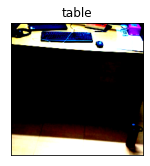

In [79]:
fig = plt.figure(figsize=(28, 8))
ax = fig.add_subplot(2, 20/2,1, xticks=[], yticks=[])
plt.imshow(np.transpose(input.cpu().numpy(), (1, 2, 0)))
ax.set_title(classes[mode[0].item()])